In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, Embedding, Conv1D, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

In [2]:
# Function for plotting the accuracy and loss for training and validation data
def acc_loss_plot(history, epochs):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xticks(range(0, epochs, 2))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')

    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xticks(range(0, epochs, 2))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss');

In [3]:
# Read in data
df = pd.read_csv('drive/MyDrive/data/df_final.csv')

In [4]:
# Check data
df

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1
18536,confortable room staff kind available polite g...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


In [65]:
# Save all class names
class_names = np.sort(df['Rating'].unique()).tolist()

## Model 1 - Regular Neural Network

In [5]:
# Split data
X = df['Review']
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [6]:
# Vectorize data
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [7]:
# Encode labels (utilises 0th index by shifting labels from 1-5 to 0-4)
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [8]:
# One hot encode labels ready for model
y_train  = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [9]:
# Show labels
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [10]:
# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train ,test_size=.2, 
                                                  stratify=y_train, random_state=42)

In [11]:
# Build model architecture
model_1 = Sequential()
model_1.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(5, activation='sigmoid'))

In [12]:
# Compile model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Fit data
epochs = 10
history_1 = model_1.fit(
    X_train, y_train, batch_size=128, epochs=epochs, verbose=0, validation_data=(X_val, y_val)
)

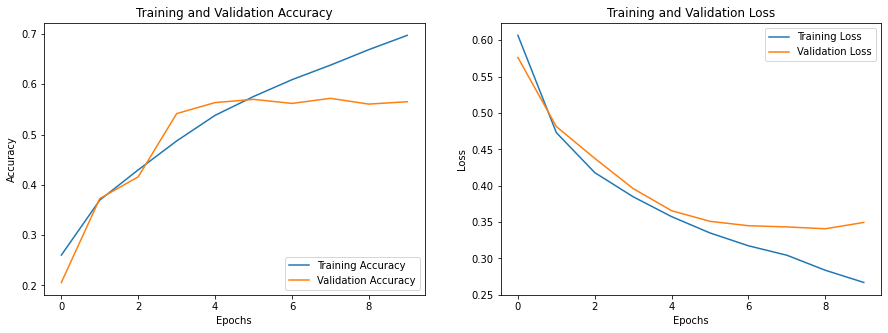

In [14]:
# Plot accuracy and loss
acc_loss_plot(history_1, epochs)

In [15]:
# Evalate model on validation set
model_1.evaluate(X_val, y_val)[1]

93/93 [==============================] - 0s 3ms/step - loss: 0.3495 - accuracy: 0.5652


0.5652173757553101

In [16]:
# Evalate model on test set
model_1.evaluate(X_test, y_test)[1]

116/116 [==============================] - 0s 3ms/step - loss: 0.3477 - accuracy: 0.5761


0.5760517716407776

In [18]:
# Save model 1
model_1.save('nn_model_1.h5')

## **Model 2** - Neural Network with Embedding Layer

In [19]:
# One hot encode target variables
df_ohe = pd.get_dummies(df, columns=['Rating'])
df_ohe

,Review,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
0,ok nothing special charge diamond member hilto...,0,1,0,0,0
1,nice room not experience hotel monaco seattle ...,0,0,1,0,0
2,excellent staff housekeeping quality hotel cho...,0,0,0,1,0
3,poor value stayed monaco seattle july nice hot...,0,1,0,0,0
4,nice hotel not nice staff hotel lovely staff q...,0,0,1,0,0
...,...,...,...,...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1,0,0,0,0
18536,confortable room staff kind available polite g...,0,0,0,0,1
18537,stayed attending itb berlin heating system hot...,0,1,0,0,0
18538,hotel well located adenauerplatz ku damm reaso...,0,1,0,0,0


In [20]:
# Split data into training and test
X = df_ohe.loc[:,['Review']]
y = np.array(df_ohe.drop('Review', axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [21]:
# Join all reviews in training set and split
train_words = " ".join(X_train['Review'].values).split()

In [22]:
# All words
len(train_words)

1122445

In [23]:
# Get all unique words only
train_unique = set(train_words)

In [24]:
# Number of unique words
len(train_unique)

30191

In [25]:
# Factorize all unique words (assign each word a unique number)
unique_idx = pd.factorize(list(train_unique))[0]

In [26]:
# Check data
list(zip(train_unique, unique_idx))[:10]

[('tiegarten', 0),
 ('marginal', 1),
 ('openned', 2),
 ('national', 3),
 ('rewarmed', 4),
 ('kp', 5),
 ('unknowingly', 6),
 ('alerternative', 7),
 ('maiden', 8),
 ('soct', 9)]

In [27]:
# Create dictionary for word and unique number
word_idx_zip = zip(train_unique, unique_idx)
word_idx = dict((x, y) for x, y in list(word_idx_zip))

In [28]:
# Adding padding and unknown for empty space and unknown words
word_idx = {k:(v+2) for k,v in word_idx.items()}
word_idx['<PAD>'] = 0
word_idx['<UNK>'] = 1

In [29]:
# Size of dict
len(word_idx)

30193

In [30]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [35]:
# Vectorize reviews in training set
X_train['vect_review'] = X_train['Review'].str.split().map(
    lambda x: [word_idx.get(word, word_idx['<UNK>']) for word in x]
)

In [36]:
# Check data
X_train

,Review,vect_review
11117,stayed night last minute stop parking limited ...,"[18677, 5241, 17260, 9433, 29245, 24712, 214, ..."
17749,hostel not used longer stay maybe young people...,"[27759, 24873, 21477, 6646, 13235, 9614, 7602,..."
9253,stayed night moment went room perfect clean mo...,"[18677, 5241, 26602, 13940, 21710, 779, 25332,..."
9986,nice hotel nice architecture right river thame...,"[364, 20345, 364, 2918, 8283, 9349, 11138, 203..."
17853,first arrive check time room isn ready hour la...,"[9022, 10164, 25565, 19727, 21710, 12159, 2662..."
...,...,...
95,great location reservation mixup great hotel s...,"[3915, 17411, 16077, 7530, 3915, 20345, 11397,..."
15433,location really great near metro station marke...,"[17411, 10314, 3915, 15568, 24373, 26209, 1159..."
7513,very basic small single bed called double no s...,"[16978, 15709, 27279, 7276, 5917, 5910, 29008,..."
12423,needed hotel stay only london day recommended ...,"[4526, 20345, 13235, 26170, 26682, 220, 3701, ..."


In [40]:
# Vectorize reviews in test set
X_test['vect_review'] = X_test['Review'].str.split().map(
    lambda x: [word_idx.get(word, word_idx['<UNK>']) for word in x]
)

In [41]:
# Check data
X_test

,Review,vect_review
10759,booked hotel booking com upon arrival hotel ou...,"[6057, 20345, 24399, 2949, 7947, 25059, 20345,..."
4996,great party people stayed lti week june fantas...,"[3915, 24340, 8942, 18677, 14774, 5120, 1194, ..."
3972,boutique relais husband recently returned pari...,"[15749, 17846, 27698, 28327, 18766, 16832, 186..."
1178,melia caribe tropical little bit heaven return...,"[7964, 8419, 27496, 13817, 7240, 26233, 18766,..."
9603,booked hotel online well advance trip olympic ...,"[6057, 20345, 29138, 19645, 18711, 6897, 23982..."
...,...,...
7717,combined business trip weekend away partner un...,"[21280, 16451, 6897, 5222, 18454, 11210, 21149..."
9494,stayed one night room covered cobweb window si...,"[18677, 27872, 5241, 21710, 19609, 16425, 2048..."
12738,staff unfriendly unhelpful good position visit...,"[17159, 9631, 25694, 3336, 9588, 18868, 26682,..."
2578,great honeymoon beautiful wife paula returned ...,"[3915, 9896, 16734, 21356, 1, 18766, 9896, 119..."


In [42]:
# Add padding to reviews and cap (train & test)
X_train = sequence.pad_sequences(
    X_train['vect_review'], value=word_idx['<PAD>'], padding='post', maxlen=200
)

X_test = sequence.pad_sequences(
    X_test['vect_review'], value=word_idx['<PAD>'], padding='post', maxlen=200
)

In [43]:
# Example
X_train[9]

array([ 9167, 24399, 25276,  5241, 25806, 20345, 16503, 27826, 12414,
        1194, 25276,  5241, 20343, 11210, 26423,  7893, 12461, 21823,
       13650,  2788, 26209, 27190, 20551, 14329, 21710,  6860, 15345,
       17772,  9855,  5241, 13688, 29008,  5917,  7276,  5917, 27626,
        5073, 26170, 25276, 28094,  8192,  8688,  7628, 21710, 13661,
       17644,  6057, 21710, 21710, 30115, 24873, 26170,  3793,  7100,
       21710,  2104,  5917, 10123, 21710, 21468, 10189, 12135,  2336,
       11147,  7100, 21710, 26170, 25276,  5917, 18949,  2832, 19551,
        4533, 12502,  9988, 28070, 10189, 12135, 24171, 25467, 21213,
       16321, 12649, 24562,  2104,  5917, 26170, 27872, 10384,  1632,
       23226, 21710,  6723, 17597, 25263, 21710, 29008,  5917,  4259,
       20345, 27646,  3545,  8872, 21710,  1087,  8942, 21710, 17356,
        7426,  9213, 20481, 10458, 15725, 16122, 14420, 12638,  1849,
       28333,  4487, 26642, 14089, 20481, 26170,  7276,   181, 24196,
       20906, 17382,

In [44]:
# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=42)

In [45]:
# Build model architecture
model_2 = Sequential()
model_2.add(Embedding(len(word_idx), 32))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(5, activation='sigmoid'))

In [46]:
# View model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          966176    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 967,397
Trainable params: 967,397
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compile model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit model
epochs = 50
history_2 = model_2.fit(
    X_train, y_train, batch_size=250, epochs=epochs, validation_data=(X_val, y_val), 
    callbacks=[early_stopping], verbose=0
)

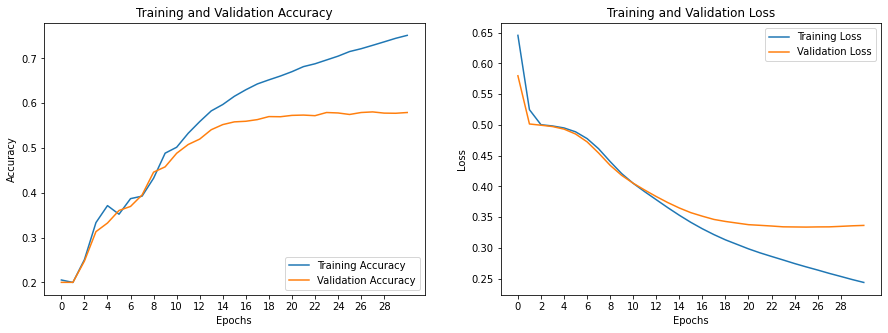

In [49]:
# Plot accuracy and loss
last_epoch = early_stopping.stopped_epoch
acc_loss_plot(history_2, last_epoch)

In [50]:
# Evalate model on validation set
model_2.evaluate(X_val, y_val)[1]

93/93 [==============================] - 0s 2ms/step - loss: 0.3367 - accuracy: 0.5794


0.5793731212615967

In [51]:
# Evaluate model on test set
model_2.evaluate(X_test, y_test)[1]

116/116 [==============================] - 0s 2ms/step - loss: 0.3393 - accuracy: 0.5939


0.5938511490821838

In [52]:
# Save model 2
model_2.save('nn_model_2.h5')

## **Model 3** - Convolutional Neural Network with Embedding Layer

In [53]:
# Build convolutional model architecture
model_3 = Sequential()
model_3.add(Embedding(len(word_idx), 32))
model_3.add(Conv1D(128, 5, activation='relu'))
model_3.add(GlobalAveragePooling1D())
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(5, activation='sigmoid'))

In [54]:
# Compile model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
# Model summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          966176    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         20608     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
Total params: 988,129
Trainable params: 988,129
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Fit model
epochs = 50
history_3 = model_3.fit(
    X_train, y_train, batch_size=250, epochs=epochs, validation_data=(X_val, y_val), 
    callbacks=[early_stopping], verbose=0
)

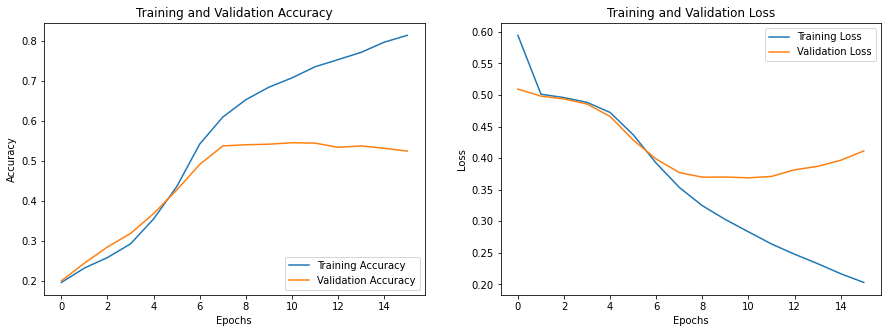

In [57]:
# Plot accuracy and loss
last_epoch = early_stopping.stopped_epoch
acc_loss_plot(history_3, last_epoch)

In [58]:
# Evalate model on validation set
model_3.evaluate(X_val, y_val)[1]

93/93 [==============================] - 1s 4ms/step - loss: 0.4113 - accuracy: 0.5241


0.5240983963012695

In [59]:
# Evaluate model on test set
model_3.evaluate(X_test, y_test)[1]

116/116 [==============================] - 1s 5ms/step - loss: 0.4191 - accuracy: 0.5299


0.5299353003501892

In [60]:
# Save model 3
model_3.save('nn_model_3.h5')

## **Evaluate Best Model**

In [61]:
# Select best model
best_model = model_2

In [62]:
# Reverse one hot encode labels
y_val_rohe = np.argmax(y_val, axis=1)+1 # For an array
y_test_rohe = np.argmax(y_test, axis=1)+1 # For an array

In [63]:
# Make predictions with best neural network model
y_test_preds = np.argmax(best_model.predict(X_test), axis=1)+1

In [64]:
# Get best model's final accuracy on test set
model_accuracy = accuracy_score(y_test_rohe, y_test_preds)

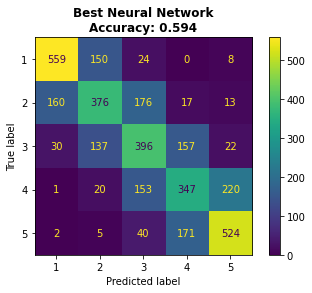

In [66]:
# Plot confusion matrix for best neural network model
cm = confusion_matrix(y_test_rohe, y_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(values_format='d')
disp.ax_.set_title(f'Best Neural Network\nAccuracy: {model_accuracy:.3f}', fontweight='bold');